In [1]:
#Configurations if kaggle is being used
kaggle = True

In [2]:
import sys
sys.path.append('.')
if kaggle:
    sys.path.append('/kaggle/input/helper-scripts3')
import os
print(os.getcwd())

/kaggle/working


In [3]:
#Kaggle doesn't have this by default
!pip install zfpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 19.2 MB/s eta 0:00:0000:01


In [4]:
import pytorch_lightning as pl
import torch
from src import data_loaders
from src.models import resnet_18
from scripts.eval_resnet18 import eval
from scripts.zfp_compress import zfp_compress
from scripts.zlib_compress import zlib_compress
import matplotlib.pyplot as plt


In [5]:
if kaggle:
    kaggle_path = '/kaggle/input/models/'
    os.makedirs('/kaggle/working/graphs/')
    kaggle_save = '/kaggle/working/graphs/'
else:
    kaggle_path=''
    kaggle_save=''

original_model = resnet_18.ResNetLightning()
ckpt = torch.load(f'{kaggle_path}models/resnet18_base_best-v1.ckpt', map_location=torch.device('cpu'))
original_model.load_state_dict(ckpt['state_dict'])
original_model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNetLightning(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [6]:
if kaggle and not os.path.isdir('/kaggle/working/models'):
    os.makedirs('/kaggle/working/models')
    print(os.listdir('/kaggle/working/models'))
# os.chdir('/kaggle/working/')

[]


In [7]:
tolerance_values = [1/2**i for i in range(-2, 27)]
results = list()

test_loader = data_loaders.cifar10_loader(train=False, num_workers=4)


accuracies = []
compression_ratios = []
model_sizes = []


count = 0
for tolerance in tolerance_values:
    zfp_model, org_size, comp_size = zfp_compress(original_model, f'resnet18_{count}', tolerance=tolerance)
    trainer_zfp = pl.Trainer()
    trials = trainer_zfp.test(zfp_model, dataloaders=test_loader)

    #Metrics
    accuracies.append(trials[0]['test_acc'])
    compression_ratios.append(org_size / comp_size)
    model_sizes.append(comp_size / 1024**2) #MB size
    count += 1


#Relevant Base Model Metrics
org_data = {}
org_trial = trainer_zfp.test(original_model, dataloaders=test_loader)

org_data['accuracy'] = trials[0]['test_acc']
org_data['compression_ratio'] = 1
org_data['model_size'] = org_size / 1024**2

#Relevant zlib Model Metrics
zlib_data = {}
_, _, zlib_size = zlib_compress(original_model, f'zlib-resnet18')
zlib_data['compression_ratio'] = org_size / zlib_size
zlib_data['model_size'] = zlib_size / 1024**2



100%|██████████| 170498071/170498071 [00:05<00:00, 29756153.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Original Size: 44806735
Compressed Size: 3877787


2024-06-04 18:40:12.173840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 18:40:12.173929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 18:40:12.286469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.302584648132324     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Original Size: 44806735
Compressed Size: 6350677


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    253.86814880371094     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 8934065


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     22.90300178527832     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 11558033


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3327000141143799     │
│         test_loss         │     4.889493942260742     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 14198625


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7687000036239624     │
│         test_loss         │    0.9209790229797363     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 16841642


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.890500009059906     │
│         test_loss         │    0.44892534613609314    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 19484457


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9013000130653381     │
│         test_loss         │    0.3811591565608978     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 22127226


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.904699981212616     │
│         test_loss         │    0.38311171531677246    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 24769930


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9049999713897705     │
│         test_loss         │    0.37334612011909485    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 27412690


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.904699981212616     │
│         test_loss         │    0.3758775293827057     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 30055482


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9057999849319458     │
│         test_loss         │    0.37344852089881897    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 32698266


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9052000045776367     │
│         test_loss         │    0.37415164709091187    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 35341050


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9056000113487244     │
│         test_loss         │    0.3737568259239197     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 37983840


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3740745186805725     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 40626648


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9056000113487244     │
│         test_loss         │    0.37395650148391724    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 43269440


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739926815032959     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 45912224


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.37397870421409607    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 48555008


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.37400269508361816    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 51197792


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739926218986511     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 53840576


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739970028400421     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 56483360


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.37399500608444214    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 59126152


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739960193634033     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 61768936


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739956319332123     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 64411720


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.37399590015411377    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 67054472


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739958107471466     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 69694240


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │     0.373995840549469     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 72260736


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739958107471466     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 72980267


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739958107471466     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 72992326


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │     0.373995840549469     │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │     0.373995840549469     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 41474261


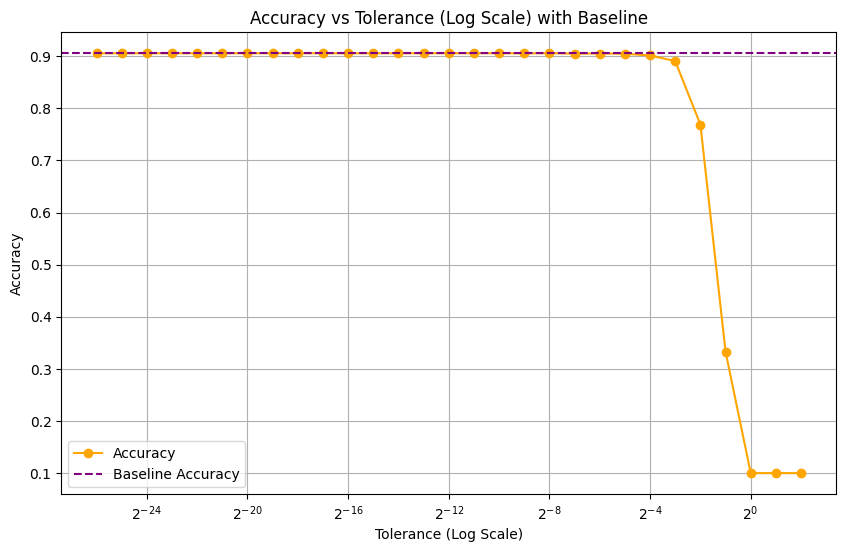

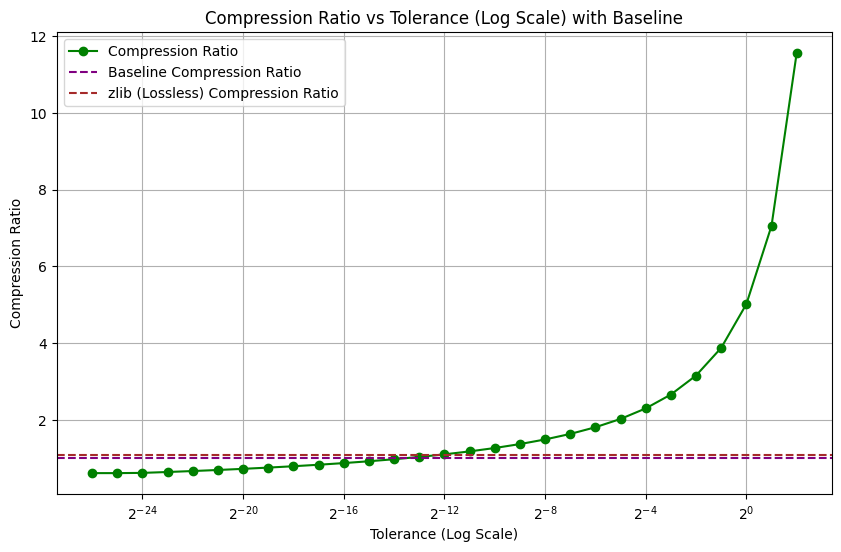

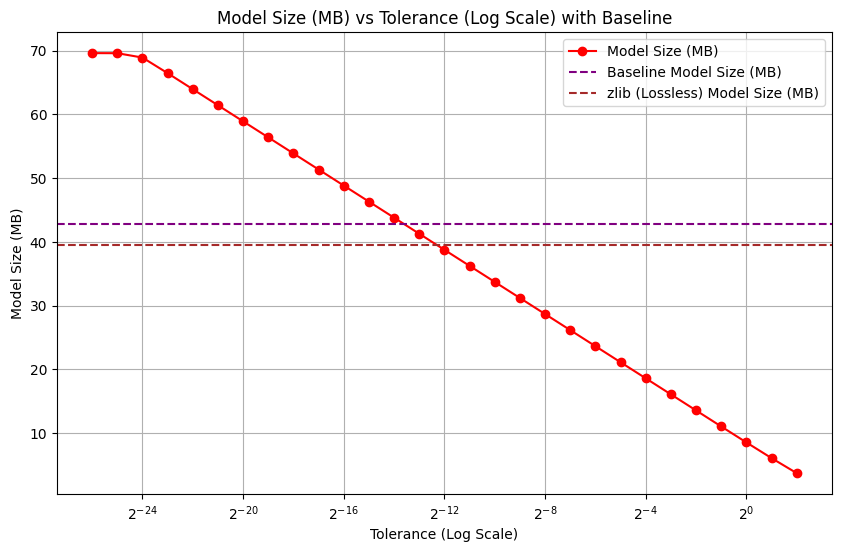

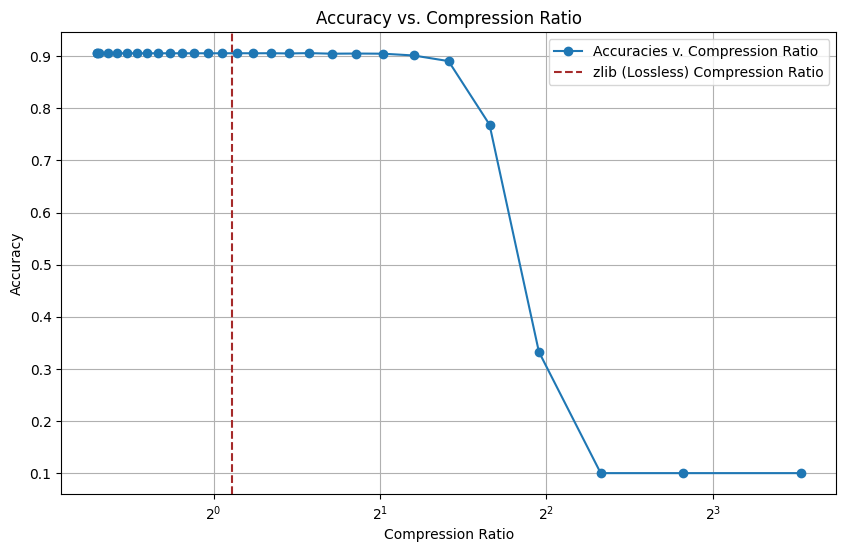

In [14]:


data = [
    (accuracies, org_data['accuracy'], 'orange', 'Accuracy'),
    (compression_ratios, org_data['compression_ratio'], 'green', 'Compression Ratio', zlib_data['compression_ratio']),
    (model_sizes, org_data['model_size'], 'red', 'Model Size (MB)', zlib_data['model_size']),
]

for d in data:
    plt.figure(figsize=(10, 6))

    plt.plot(tolerance_values, d[0], color=d[2], marker='o', label=d[3])
    plt.axhline(y=d[1], color='purple', linestyle='--', label=f'Baseline {d[3]}')
    
    if len(d) > 4:
        plt.axhline(y=d[4], color='brown', linestyle='--', label=f'zlib (Lossless) {d[3]}')


    plt.title(f'{d[3]} vs Tolerance (Log Scale) with Baseline')
    plt.xscale('log', base=2)
    plt.xlabel('Tolerance (Log Scale)')
    plt.ylabel(d[3])
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{kaggle_save}{d[3]}.png")

    plt.show()
    
plt.figure(figsize=(10, 6))
plt.plot(compression_ratios, accuracies, marker='o', label="Accuracies v. Compression Ratio")
plt.title(f'Accuracy vs. Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('Accuracy')
#Compressed Baseline
plt.axvline(x=data[1][4], color='brown', linestyle='--', label=f'zlib (Lossless) {data[1][3]}')
plt.xscale('log', base=2)
plt.legend()
plt.grid(True)
plt.savefig(f"{kaggle_save}acc_v_comp.png")
plt.show()